<a href="https://colab.research.google.com/github/SoniyaGulia/colab/blob/main/task_3_for_owl_intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Stock Price Predictoin***



import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve, \
    RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import RocCurveDisplay
import joblib
from sklearn.impute import KNNImputer
import calendar
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
df = pd.read_csv("/content/stocks.csv")
df.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


In [ ]:
def check_df(dataframe, head=5):
    print(dataframe.shape)
    print(dataframe.dtypes)
    print(dataframe.head(head))
    print(dataframe.tail(head))
    print(dataframe.isnull().sum())
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

(248, 8)
Ticker        object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
  Ticker        Date        Open        High         Low       Close  \
0   AAPL  2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL  2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL  2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL  2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL  2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume  
0  154.414230  83322600  
1  151.688400  64120100  
2  150.639999  56007100  
3  151.009995  57450700  
4  153.850006  62199000  
    Ticker        Date        Open        High         Low       Close  \
243   GOOG  2023-05-01  107.720001  108.680000  107.500000  107.709999   
244   GOOG  2023-05-02  107.660004  107.730003  104.500000  105.980003  

In [ ]:
df["Ticker"].value_counts()

,count
Ticker,
AAPL,62
MSFT,62
NFLX,62
GOOG,62


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [ ]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Weekday"] = df["Date"].dt.weekday
df["is_weekend"] = df["Weekday"].apply(lambda x: 1 if x >= 5 else 0)
df["Day_of_Year"] = df["Date"].dt.dayofyear
df["Quarter"] = df["Date"].dt.quarter
df["Days_in_Month"] = df.apply(lambda row: calendar.monthrange(row["Year"], row["Month"])[1], axis=1)

# Günlük sin ve cos dönüşümleri (ayın uzunluğuna göre ölçekleme)
df["Day_sin"] = np.sin(2 * np.pi * df["Day"] / df["Days_in_Month"])
df["Day_cos"] = np.cos(2 * np.pi * df["Day"] / df["Days_in_Month"])
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

# Yılın gününe göre sin ve cos dönüşümleri (Seasonality için)
df["Day_of_Year_sin"] = np.sin(2 * np.pi * df["Day_of_Year"] / 365)
df["Day_of_Year_cos"] = np.cos(2 * np.pi * df["Day_of_Year"] / 365)

df = df.drop(columns=["Days_in_Month", "Day", "Month", "Year", "Day_of_Year"])

print(df.head())

  Ticker       Date        Open        High         Low       Close  \
0   AAPL 2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL 2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL 2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL 2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL 2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume  Weekday  is_weekend  Quarter   Day_sin       Day_cos  \
0  154.414230  83322600        1           0        1  1.000000  6.123234e-17   
1  151.688400  64120100        2           0        1  0.974928 -2.225209e-01   
2  150.639999  56007100        3           0        1  0.900969 -4.338837e-01   
3  151.009995  57450700        4           0        1  0.781831 -6.234898e-01   
4  153.850006  62199000        0           0        1  0.222521 -9.749279e-01   

   Month_sin  Month_cos  Day_of_Year_sin  Day_of_Year_cos  
0   0.866025        0.5   

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Ticker           248 non-null    object        
 1   Date             248 non-null    datetime64[ns]
 2   Open             248 non-null    float64       
 3   High             248 non-null    float64       
 4   Low              248 non-null    float64       
 5   Close            248 non-null    float64       
 6   Adj Close        248 non-null    float64       
 7   Volume           248 non-null    int64         
 8   Weekday          248 non-null    int32         
 9   is_weekend       248 non-null    int64         
 10  Quarter          248 non-null    int32         
 11  Day_sin          248 non-null    float64       
 12  Day_cos          248 non-null    float64       
 13  Month_sin        248 non-null    float64       
 14  Month_cos        248 non-null    float64  

In [ ]:
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

In [ ]:
df.head()

,Ticker,Open,High,Low,Close,Adj Close,Volume,Weekday,is_weekend,Quarter,Day_sin,Day_cos,Month_sin,Month_cos,Day_of_Year_sin,Day_of_Year_cos
Date,,,,,,,,,,,,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572
2023-02-07,MSFT,260.529999,268.769989,260.079987,267.559998,266.891510,50841400,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572
2023-02-07,GOOG,103.629997,108.669998,103.547997,108.040001,108.040001,33738800,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572
2023-02-07,NFLX,358.510010,364.179993,354.179993,362.950012,362.950012,6289400,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572
2023-02-08,GOOG,102.690002,103.580002,98.455002,100.000000,100.000000,73546000,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980


In [ ]:
df['Target'] = df.groupby('Ticker')['Adj Close'].shift(-1)  # Bir sonraki günün fiyatını target yap

In [ ]:
df.head(20)

,Ticker,Open,High,Low,Close,Adj Close,Volume,Weekday,is_weekend,Quarter,Day_sin,Day_cos,Month_sin,Month_cos,Day_of_Year_sin,Day_of_Year_cos,Target
Date,,,,,,,,,,,,,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572,151.688400
2023-02-07,MSFT,260.529999,268.769989,260.079987,267.559998,266.891510,50841400,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572,266.063599
2023-02-07,GOOG,103.629997,108.669998,103.547997,108.040001,108.040001,33738800,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572,100.000000
2023-02-07,NFLX,358.510010,364.179993,354.179993,362.950012,362.950012,6289400,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572,366.829987
2023-02-08,GOOG,102.690002,103.580002,98.455002,100.000000,100.000000,73546000,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980,95.459999
2023-02-08,MSFT,273.200012,276.760010,266.209991,266.730011,266.063599,54686000,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980,262.961365
2023-02-08,AAPL,153.880005,154.580002,151.169998,151.919998,151.688400,64120100,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980,150.639999
2023-02-08,NFLX,360.019989,368.190002,358.309998,366.829987,366.829987,6253200,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980,362.500000
2023-02-09,MSFT,273.799988,273.980011,262.799988,263.619995,262.961365,42375100,3,0,1,0.900969,-4.338837e-01,0.866025,0.5,0.635432,0.772157,262.442657


In [ ]:
df.isnull().sum()

,0
Ticker,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Weekday,0
is_weekend,0
Quarter,0


In [ ]:
df.dropna(subset=["Target"],inplace=True)

In [ ]:
df.isnull().sum()

,0
Ticker,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Weekday,0
is_weekend,0
Quarter,0


In [ ]:
df['Close_Adj_Diff'] = df['Adj Close'] - df['Close']

In [ ]:
print(df['Close_Adj_Diff'].describe())

count    244.000000
mean      -0.019287
std        0.106384
min       -0.679993
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000000
Name: Close_Adj_Diff, dtype: float64


In [ ]:
print(df.head())
print(df.isnull().sum())

           Ticker        Open        High         Low       Close   Adj Close  \
Date                                                                            
2023-02-07   AAPL  150.639999  155.229996  150.639999  154.649994  154.414230   
2023-02-07   MSFT  260.529999  268.769989  260.079987  267.559998  266.891510   
2023-02-07   GOOG  103.629997  108.669998  103.547997  108.040001  108.040001   
2023-02-07   NFLX  358.510010  364.179993  354.179993  362.950012  362.950012   
2023-02-08   GOOG  102.690002  103.580002   98.455002  100.000000  100.000000   

              Volume  Weekday  is_weekend  Quarter   Day_sin       Day_cos  \
Date                                                                         
2023-02-07  83322600        1           0        1  1.000000  6.123234e-17   
2023-02-07  50841400        1           0        1  1.000000  6.123234e-17   
2023-02-07  33738800        1           0        1  1.000000  6.123234e-17   
2023-02-07   6289400        1           0 

In [ ]:
df['Daily_Return'] = df.groupby('Ticker')['Adj Close'].pct_change()

In [ ]:
df["MA_5"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.rolling(window=5).mean())
df["MA_10"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.rolling(window=10).mean())

In [ ]:
df["Volatilite"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.rolling(window=5).std())

In [ ]:
def compute_rsi(series, window=14):
    delta = series.diff()

    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Kazançları al
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Kayıpları al

    rs = gain / loss

    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: compute_rsi(x, window=14))

# Task
Explain the error in the selected code, fix it if possible, and incorporate the changes into the existing code.

## Handle missing values

### Subtask:
Inspect the dataframe for any missing values, especially in the newly created features, and address them appropriately (e.g., by imputation or dropping rows).


**Reasoning**:
Check for missing values in the dataframe, particularly in the newly created features, to understand the extent of the missing data problem.



In [ ]:
print(df.isnull().sum())

Ticker              0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
Weekday             0
is_weekend          0
Quarter             0
Day_sin             0
Day_cos             0
Month_sin           0
Month_cos           0
Day_of_Year_sin     0
Day_of_Year_cos     0
Target              0
Close_Adj_Diff      0
Daily_Return        4
MA_5               16
MA_10              36
Volatilite         16
RSI                52
dtype: int64


**Reasoning**:
Drop rows with missing values since the NaNs are primarily in the technical indicators due to the rolling window calculation and represent a lack of historical data for those initial rows.



In [ ]:
df.dropna(inplace=True)
print(df.isnull().sum())

Ticker             0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Weekday            0
is_weekend         0
Quarter            0
Day_sin            0
Day_cos            0
Month_sin          0
Month_cos          0
Day_of_Year_sin    0
Day_of_Year_cos    0
Target             0
Close_Adj_Diff     0
Daily_Return       0
MA_5               0
MA_10              0
Volatilite         0
RSI                0
dtype: int64


## Prepare data for modeling

### Subtask:
Separate the features (X) and the target variable (y).


**Reasoning**:
Separate the features (X) and the target variable (y) by dropping the 'Target' and 'Ticker' columns from df to create X and assigning the 'Target' column to y.



In [ ]:
X = df.drop(columns=['Target', 'Ticker'])
y = df['Target']

## Split data

### Subtask:
Split the data into training and testing sets.


**Reasoning**:
Split the data into training and testing sets while maintaining the time series order.



## Scale features

### Subtask:
Scale the numerical features to ensure they have similar ranges.


**Reasoning**:
Identify and scale the numerical features in the training and testing sets using StandardScaler.



In [ ]:
numerical_cols = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

display(X_train.head())
display(X_test.head())

,Open,High,Low,Close,Adj Close,Volume,Weekday,is_weekend,Quarter,Day_sin,...,Month_sin,Month_cos,Day_of_Year_sin,Day_of_Year_cos,Close_Adj_Diff,Daily_Return,MA_5,MA_10,Volatilite,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-27,-0.737977,-0.743413,-0.726542,-0.741624,-0.741624,0.660641,-1.384524,0.0,-0.728011,-0.440640,...,-1.228087,2.316146,-2.468420,1.566326,0.0,0.280410,-0.727132,-0.686690,-0.922433,-1.162088
2023-02-27,1.242426,1.262814,1.271278,1.231302,1.231302,-1.156398,-1.384524,0.0,-0.728011,-0.440640,...,-1.228087,2.316146,-2.468420,1.566326,0.0,0.848969,1.289299,1.454663,1.888925,-1.602371
2023-02-27,0.439630,0.406537,0.439416,0.410292,0.410292,-0.452729,-1.384524,0.0,-0.728011,-0.440640,...,-1.228087,2.316146,-2.468420,1.566326,0.0,0.033174,0.437737,0.527376,-0.499079,-1.404162
2023-02-27,-1.385745,-1.394885,-1.388098,-1.393069,-1.393069,-0.380980,-1.384524,0.0,-0.728011,-0.440640,...,-1.228087,2.316146,-2.468420,1.566326,0.0,0.288500,-1.374006,-1.336785,-0.883376,-2.440033
2023-02-28,1.240515,1.236409,1.260413,1.221162,1.221162,-1.271741,-0.659071,0.0,-0.728011,-0.109166,...,-1.228087,2.316146,-2.269477,1.511525,0.0,-0.329080,1.254662,1.413697,1.112761,-1.618307


,Open,High,Low,Close,Adj Close,Volume,Weekday,is_weekend,Quarter,Day_sin,...,Month_sin,Month_cos,Day_of_Year_sin,Day_of_Year_cos,Close_Adj_Diff,Daily_Return,MA_5,MA_10,Volatilite,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-21,1.232645,1.243843,1.241312,1.287073,1.287073,-1.146793,1.517286,0.0,1.373606,-1.525886,...,-1.228087,-1.263352,-0.259349,-1.729615,0.0,0.271357,1.304308,1.365952,0.394951,-1.063723
2023-04-21,-1.205872,-1.215264,-1.206524,-1.214941,-1.214941,-0.397557,1.517286,0.0,1.373606,-1.525886,...,-1.228087,-1.263352,-0.259349,-1.729615,0.0,-0.169960,-1.207245,-1.187805,-1.087341,0.007579
2023-04-21,-0.543039,-0.551699,-0.531644,-0.548962,-0.548962,1.284410,1.517286,0.0,1.373606,-1.525886,...,-1.228087,-1.263352,-0.259349,-1.729615,0.0,-0.715469,-0.525261,-0.535327,-0.906268,-0.272521
2023-04-24,1.313588,1.314515,1.324235,1.298790,1.298790,-1.182399,-1.384524,0.0,1.373606,-1.525886,...,-1.228087,-1.263352,-0.658815,-1.911231,0.0,-0.000021,1.295970,1.354744,0.181627,-1.165224
2023-04-24,-0.543601,-0.561129,-0.538506,-0.545469,-0.545469,0.518063,-1.384524,0.0,1.373606,-1.525886,...,-1.228087,-1.263352,-0.658815,-1.911231,0.0,-0.071407,-0.525036,-0.531617,-0.914357,-0.416959


## Train models

### Subtask:
Train different regression models on the training data.


**Reasoning**:
Initialize and train the specified regression models using the training data.



In [ ]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor()
lgbm_model = LGBMRegressor()
xgb_model = XGBRegressor()
dt_model = DecisionTreeRegressor()

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 153, number of used features: 19
[LightGBM] [Info] Start training from score 214.197975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

DecisionTreeRegressor()

## Evaluate models

### Subtask:
Evaluate the performance of the trained models on the testing data using appropriate metrics (e.g., MAE, MSE, R2).


**Reasoning**:
Evaluate the performance of the trained models on the testing data using appropriate metrics (e.g., MAE, MSE, R2) and print the results.



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    "Linear Regression": lr_model,
    "Random Forest": rf_model,
    "LGBM": lgbm_model,
    "XGBoost": xgb_model,
    "Decision Tree": dt_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"--- {name} ---")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    print("-" * (len(name) + 8))

--- Linear Regression ---
MAE: 3.8719
MSE: 26.3706
R2: 0.9968
-------------------------
--- Random Forest ---
MAE: 4.8043
MSE: 43.1263
R2: 0.9948
---------------------
--- LGBM ---
MAE: 5.1744
MSE: 45.7048
R2: 0.9945
------------
--- XGBoost ---
MAE: 3.3010
MSE: 27.4312
R2: 0.9967
---------------
--- Decision Tree ---
MAE: 8.5083
MSE: 171.1626
R2: 0.9794
---------------------


## Improve models (optional)

### Subtask:
Tune the hyperparameters of the best performing models (XGBoost and Linear Regression) to potentially improve performance.


**Reasoning**:
Define parameter grids for XGBoost and Linear Regression, then use RandomizedSearchCV to tune the XGBoost model. Linear Regression does not require hyperparameter tuning. Evaluate the tuned XGBoost model and the Linear Regression model on the test set and print the metrics.



In [ ]:
df = pd.get_dummies(df,columns=["Ticker"],drop_first=True,dtype=int)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2023-02-27 to 2023-05-04
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             192 non-null    float64
 1   High             192 non-null    float64
 2   Low              192 non-null    float64
 3   Close            192 non-null    float64
 4   Adj Close        192 non-null    float64
 5   Volume           192 non-null    int64  
 6   Weekday          192 non-null    int32  
 7   is_weekend       192 non-null    int64  
 8   Quarter          192 non-null    int32  
 9   Day_sin          192 non-null    float64
 10  Day_cos          192 non-null    float64
 11  Month_sin        192 non-null    float64
 12  Month_cos        192 non-null    float64
 13  Day_of_Year_sin  192 non-null    float64
 14  Day_of_Year_cos  192 non-null    float64
 15  Target           192 non-null    float64
 16  Close_Adj_Diff   192 non-null    float64
 1

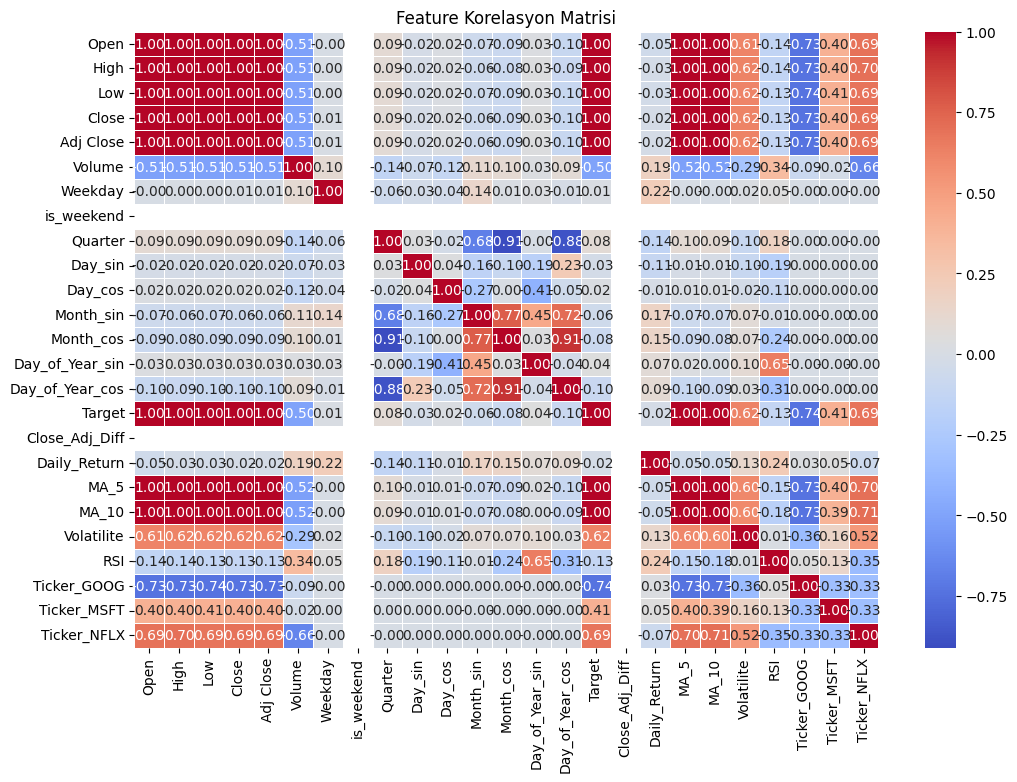

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Korelasyon Matrisi")
plt.show()